In [60]:
from PIL import Image
import numpy as np
import cv2
from scipy.ndimage import convolve

def resize_image(img, output_path, size=(400, 400)):
    """Resize the image to the specified size and save it."""
    img = Image.fromarray(img)
    resized_img = img.resize(size)
    return np.array(resized_img)

In [61]:
def otsu_threshold_float(image, num_bins=256):
    hist, bin_edges = np.histogram(image.flatten(), bins=num_bins, range=(0, 1))
    total_pixels = image.size
    hist_prob = hist / total_pixels
    bin_centers = (bin_edges[:-1] + bin_edges[1:]) / 2
    current_max_variance = 0
    threshold = 0
    total_mean = np.sum(hist_prob * bin_centers)
    background_weight = 0
    background_mean = 0
    for t in range(num_bins):
        background_weight += hist_prob[t]
        if background_weight == 0:
            continue
        foreground_weight = 1 - background_weight
        if foreground_weight == 0:
            break
        background_mean += bin_centers[t] * hist_prob[t] / background_weight
        foreground_mean = (total_mean - background_weight * background_mean) / foreground_weight
        between_class_variance = (
            background_weight * foreground_weight * (background_mean - foreground_mean) ** 2
        )
        if between_class_variance > current_max_variance:
            current_max_variance = between_class_variance
            threshold = bin_centers[t]
    return threshold

In [62]:
import matplotlib.pyplot as plt

def calc_gaussian_kernel(sigma):
    size = int(2 * np.ceil(3 * sigma) + 1)
    x, y = np.mgrid[-size // 2 + 1:size // 2 + 1, -size // 2 + 1:size // 2 + 1]
    g = np.exp(-(x**2 + y**2) / (2 * sigma**2))
    return g / g.sum()

def make_positive(angle):
    return angle % 360

def canny_detector(img):
    # Load the image
    ct_img = cv2.cvtColor(img, cv2.COLOR_BGR2GRAY)
        
    ct_img = resize_image(ct_img, (400, 400))
    
    ct_img = ct_img.astype(np.float64) / 255.0
    ct_img = (ct_img - np.min(ct_img)) / (np.max(ct_img) - np.min(ct_img))


    # Determine thresholds
    const = .6
    image_mean = np.mean(ct_img)
    image_std = np.std(ct_img) / 2
    lower_bound = max(0, image_mean - image_std)
    upper_bound = min(1, image_mean + image_std)
    threshold_l = max(0, const * lower_bound) 
    threshold_h = min(1, const * upper_bound)
    print(threshold_l, threshold_h)

    # Apply Gaussian filter
    sigma = 3
    B = calc_gaussian_kernel(sigma)
    ct_img_gauss = convolve(ct_img, B, mode='reflect')
    # Sobel kernels
    Bx = np.array([[-1, 0, 1], [-2, 0, 2], [-1, 0, 1]])
    By = np.array([[1, 2, 1], [0, 0, 0], [-1, -2, -1]])

    # Bx = np.array([[-3, 0, 3], [-10, 0, 10], [-3, 0, 3]])
    # By = np.array([[-3, -10, -3], [0, 0, 0], [3, 10, 3]])
    ct_sobel_x = convolve(ct_img_gauss, Bx, mode='reflect')
    ct_sobel_y = convolve(ct_img_gauss, By, mode='reflect')

    # Edge gradient and angles
    edge_gradient = np.sqrt(ct_sobel_x**2 + ct_sobel_y**2)
    angle = np.arctan2(ct_sobel_y, ct_sobel_x) * (180 / np.pi)
    angle = np.where(angle < 0, angle + 360, angle)

    # Quantize angles to 0, 45, 90, 135
    angle_d = np.zeros_like(angle)
    angle_d[np.logical_or.reduce([
        (angle >= 0) & (angle < 22.5),
        (angle >= 157.5) & (angle < 202.5),
        (angle >= 337.5) & (angle <= 360)
    ])] = 0
    angle_d[np.logical_or.reduce([
        (angle >= 22.5) & (angle < 67.5),
        (angle >= 202.5) & (angle < 247.5)
    ])] = 45
    angle_d[np.logical_or.reduce([
        (angle >= 67.5) & (angle < 112.5),
        (angle >= 247.5) & (angle < 292.5)
    ])] = 90
    angle_d[np.logical_or.reduce([
        (angle >= 112.5) & (angle < 157.5),
        (angle >= 292.5) & (angle < 337.5)
    ])] = 135

    plt.imshow(edge_gradient, cmap="gray")
    plt.show()
    # Non-maximum suppression
    edges = np.zeros_like(edge_gradient)
    for i in range(1, edge_gradient.shape[0] - 1):
        for j in range(1, edge_gradient.shape[1] - 1):
            current = edge_gradient[i, j]
            if angle_d[i, j] == 0:
                neighbors = [edge_gradient[i, j - 1], edge_gradient[i, j + 1]]
            elif angle_d[i, j] == 45:
                neighbors = [edge_gradient[i - 1, j + 1], edge_gradient[i + 1, j - 1]]
            elif angle_d[i, j] == 90:
                neighbors = [edge_gradient[i - 1, j], edge_gradient[i + 1, j]]
            elif angle_d[i, j] == 135:
                neighbors = [edge_gradient[i - 1, j - 1], edge_gradient[i + 1, j + 1]]
            edges[i, j] = current if current >= max(neighbors) else 0

    plt.imshow(edges, cmap="gray")
    plt.show()
    # Double thresholding and hysteresis
    strong_edges = edges >= threshold_h
    weak_edges = (edges < threshold_h) & (edges >= threshold_l)

    final_edges = np.zeros_like(edges)
    final_edges[strong_edges] = 1

    for i in range(1, edges.shape[0] - 1):
        for j in range(1, edges.shape[1] - 1):
            if weak_edges[i, j]:
                if np.any(strong_edges[i - 1:i + 2, j - 1:j + 2]):
                    final_edges[i, j] = 1

    # Save the final result
    final_edges = final_edges.astype(np.uint8)
    return final_edges


In [63]:
import matplotlib.pyplot as plt

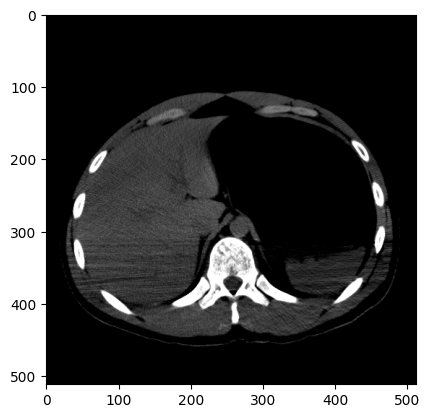

In [64]:
img = cv2.imread("data/0005.png")
plt.imshow(img)
img = cv2.cvtColor(img, cv2.COLOR_BGR2GRAY)

In [65]:
np.min(img), np.max(img), img.shape

(np.uint8(0), np.uint8(255), (512, 512))

In [66]:
img = resize_image(img, (400, 400))
img = cv2.cvtColor(img, cv2.COLOR_GRAY2BGR)

0.0014779909419878085 0.11921521494036513


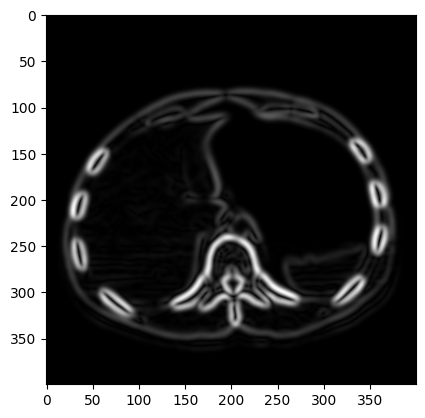

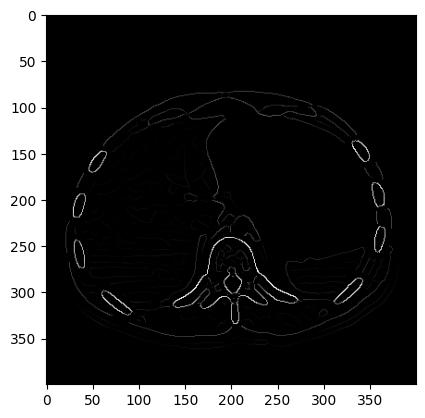

In [67]:
cimg = canny_detector(img)

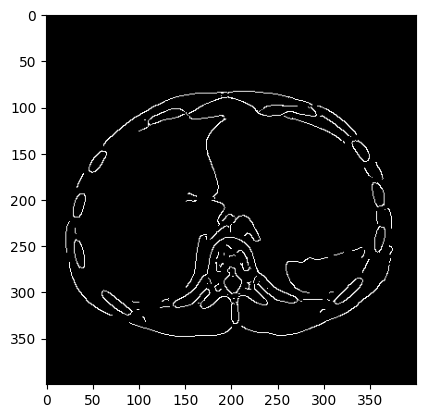

In [68]:
plt.imshow(cimg,cmap="gray")

In [69]:
i = cv2.Canny(img, 100, 200)

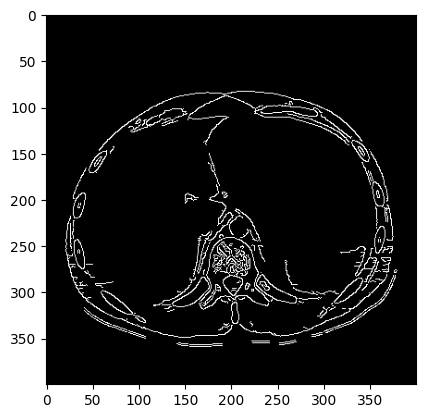

In [70]:
plt.imshow(i, cmap="gray")

In [71]:
np.where(cimg == i)[0].shape[0] / (400*400)

0.95063125

In [ ]:
def metrics(ours, cv2):
    tp = np.where(ours == 1)[0].shape[0]7 / (400*400)
    